<a href="https://colab.research.google.com/github/Harsh-Git-Hub/Batoonee/blob/dev/textgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!pip install tensorflow-addons

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
import seaborn as sns

import string, re
import os
import time
from datetime import date
import unicodedata

#Utils

In [ ]:
def is_gpu_available():
    # return len(device_lib.list_local_devices()) > 0
    return False
    
print(is_gpu_available())

def visualize_gan_loss(gan_history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)
    ax[0].plot(gan_history.history["gen_loss"])
    ax[0].grid()
    ax[0].set_title("Generator Loss", fontdict={"size":14})

    ax[1].plot(gan_history.history["disc_loss"])
    ax[1].grid()
    ax[1].set_title("Discriminator Loss", fontdict={"size":14})

    fig.text(x=0.5, y=0.01, s="Epochs")

    fig.tight_layout()

False


#Dataset Handler

In [ ]:
class DatasetHandler:
    def __init__(self):
        self.inp_lang_tokenizer = None
        self.targ_lang_tokenizer = None

    def unicode_to_ascii(self, s):
        # s = emoji.demojize(s)
        return ''.join(c for c in unicodedata.normalize('NFD', s) \
                       if unicodedata.category(c) != 'Mn')

    def preprocess_sentence(self, w):
        w = self.unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        w = w.replace('<end>', '').replace('<start>', '')
        w = re.sub(r"([?.!,])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z0-9?.!,']+", " ", w)
        w = w.strip()
        # w = '<start> ' + w + ' <end>'
        return w

    def tokenize(self, lang):
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
            filters='', oov_token='<OOV>')
        
        lang_tokenizer.fit_on_texts(lang)
        tensor = lang_tokenizer.texts_to_sequences(lang) 
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                               padding='post')
        return tensor, lang_tokenizer
    
    def _load_coqa(self, num_examples):
        ds = tfds.load("coqa", split="train", shuffle_files=False)
    
        Xy = []
        history_size = 3
        
        for entry in ds.take(num_examples):
            prepr = self.preprocess_sentence(
                entry["story"].numpy().decode('utf-8')
            )

            st = prepr + " "
            lastans = ''
            hist = 0 
            for j in range(len(entry["questions"])):
                ans = entry["answers"]['input_text'][j].numpy().decode(
                    "utf-8")      
                      
                ques = entry["questions"][j].numpy().decode("utf-8")

                if len(ques.split(' ')) >= 5 \
                and len(ans.split(' ')) >= 3:
                    if hist < history_size:
                        if lastans != '':
                            st += " " + lastans + ". "
                            hist += 1
                    else:
                        hist = 0
                        st = prepr +  " "

                    lastans = ans
                    st += " " + ques + " "
                    Xy.append(["<start> " + st + " <end>", "<start> " \
                               + ans + " <end>"])
        return zip(*Xy)

    def load_data(self, batch_size, num_examples):
        inp_lang, targ_lang = self._load_coqa(num_examples)
        input_tensor, inp_lang_tokenizer = self.tokenize(inp_lang)
        target_tensor, targ_lang_tokenizer = self.tokenize(targ_lang)
        
        train_data = tf.data.Dataset.from_tensor_slices((
            input_tensor,
            target_tensor
        )).batch(batch_size, drop_remainder=True)

        return train_data, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
handler = DatasetHandler()

In [ ]:
batch_size = 16
num_examples = 64

train_data, inp_lang, targ_lang = handler.load_data(batch_size, num_examples)

In [ ]:
example_input_batch, example_target_batch = next(iter(train_data))

In [ ]:
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1
max_length_input = example_input_batch.shape[1]
max_length_output = example_target_batch.shape[1]

latent_dim = 256

In [ ]:
print("max_length_ques, max_length_ans, vocab_size_ques, vocab_size_ans")
max_length_input, max_length_output, vocab_inp_size, vocab_tar_size, latent_dim

max_length_ques, max_length_ans, vocab_size_ques, vocab_size_ans


(440, 26, 4272, 573, 256)

#Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, 
                 add_gaussian_noise=False, **kwargs):
        
        super(Encoder, self).__init__(**kwargs)
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                   embedding_dim)
        gpu = is_gpu_available()
        flstm = None
        blstm = None
        if not gpu:
            flstm = tf.keras.layers.LSTM(
                        self.enc_units,
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform',
                        trainable=True
                    )
            blstm = tf.keras.layers.LSTM(
                        self.enc_units,
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform',
                        go_backwards=True,
                        trainable=True
                    )
        else:
            flstm = tf.compat.v1.keras.layers.CuDNNLSTM(
                self.enc_units,
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform',
                trainable=True
            )

            blstm = tf.compat.v1.keras.layers.CuDNNLSTM(
                self.enc_units,
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform',
                go_backwards=True,
                trainable=True
            )
            
        self.bilstm_layer = tf.keras.layers.Bidirectional(
            flstm,
            backward_layer=blstm,
            trainable=True
        )

        self.add_gaussian_noise = add_gaussian_noise

    def build_graph(self):
        enc_inp = tf.keras.Input(shape=(None, ))
        return tf.keras.Model(enc_inp, self.call(enc_inp))

    def call(self, x, hidden=None):
        if hidden is None:
            hidden = self.initialize_hidden_state()
        x = self.embedding(x)
        output, fh, fc, bh, bc = self.bilstm_layer(x, 
                                                   initial_state = hidden)

        h = tf.keras.layers.Concatenate()([fh, bh])
        c = tf.keras.layers.Concatenate()([fc, bc])

        if self.add_gaussian_noise:
            h = tf.keras.layers.GaussianNoise(0.1)(h)
            c = tf.keras.layers.GaussianNoise(0.1)(c)

        return output, h, c

    def initialize_hidden_state(self):
        init_state = [tf.zeros((self.batch_sz, self.enc_units)) \
                      for i in range(4)]
        return init_state

In [ ]:
encoder = Encoder(
    vocab_inp_size,
    latent_dim,
    latent_dim,
    batch_size,
    add_gaussian_noise=True
)

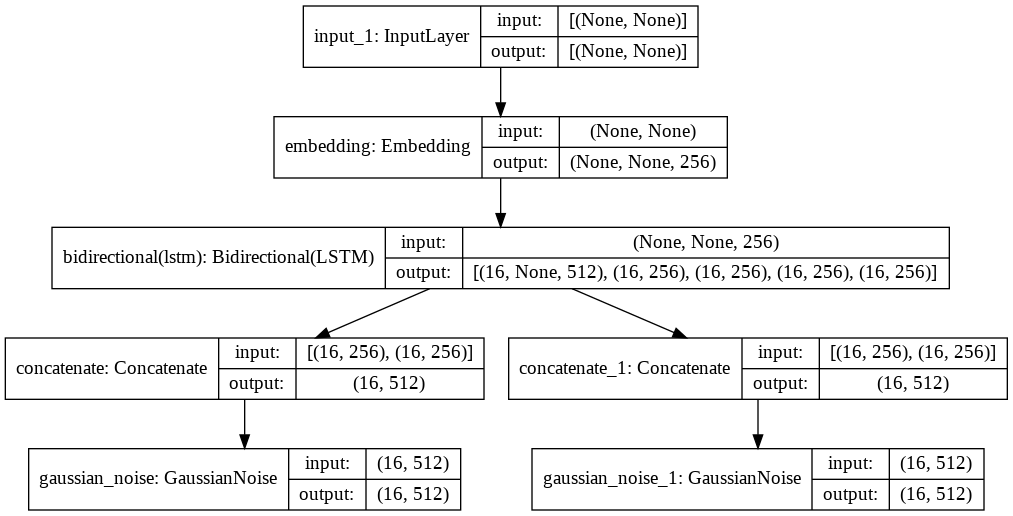

In [ ]:
tf.keras.utils.plot_model(
    encoder.build_graph(),
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
enc_sample_out, enc_sample_h, enc_sample_c = encoder(example_input_batch)

#Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, 
                 dec_units, batch_sz, 
                 attention_type='luong', sampler_fn=None):
        
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.attention_type = attention_type

        # int(vocab_size ** 0.25) for embedding_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                   embedding_dim)

        self.fc = tf.keras.layers.Dense(vocab_size)

        self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)

        if not sampler_fn:
            self.sampler = tfa.seq2seq.TrainingSampler()
            # sampler = GumbelSampler()
        else:
            self.sampler = sampler_fn

        self.attention_mechanism = self.build_attention_mechanism(
            self.dec_units, 
            None, 
            tf.fill([self.batch_sz], max_length_input), 
            self.attention_type
        )

        self.rnn_cell = self.build_rnn_cell(batch_sz)

        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, 
                                                sampler=self.sampler, 
                                                output_layer=self.fc)


    def build_rnn_cell(self, batch_sz):
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
                                    self.attention_mechanism, 
                                    attention_layer_size=self.dec_units,
                                    alignment_history=True)
        return rnn_cell

    def build_attention_mechanism(self, dec_units, memory, 
                                  memory_sequence_length, 
                                  attention_type='luong'):
        if(attention_type=='bahdanau'):
            return tfa.seq2seq.BahdanauAttention(
                units=dec_units,
                memory=memory,
                memory_sequence_length=memory_sequence_length)
        else:
            return tfa.seq2seq.LuongAttention(
                units=dec_units, 
                memory=memory, 
                memory_sequence_length=memory_sequence_length
            )

    def build_initial_state(self, batch_sz, encoder_state, Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(
            batch_size=batch_sz, 
            dtype=Dtype
        )
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state
        )
        return decoder_initial_state

    def call(self, inputs, initial_state):
        x = self.embedding(inputs)
        outputs, dec_states, _ = self.decoder(
            x, 
            initial_state=initial_state, 
            sequence_length=tf.fill([self.batch_sz], max_length_output - 1)
        )
        return outputs, dec_states

In [ ]:
decoder = Decoder(
    vocab_tar_size,
    latent_dim,
    latent_dim * 2,
    batch_size
)

In [ ]:
decoder.attention_mechanism.setup_memory(enc_sample_out)
dec_sample_init_state = decoder.build_initial_state(
    batch_size,
    [enc_sample_h, enc_sample_c],
    tf.float32
)
dec_sample_out, _ = decoder(example_target_batch, dec_sample_init_state)

In [ ]:
dec_sample_out.rnn_output.shape

TensorShape([16, 25, 573])

#GAN

##Generator

In [ ]:
class Generator(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, inputs, training=False):
        inp, targ = inputs
        enc_hidden = self.encoder.initialize_hidden_state()

        enc_output, enc_h, enc_c = self.encoder(inp, enc_hidden)

        dec_input = targ[ : , : -1]
        self.decoder.attention_mechanism.setup_memory(enc_output)
        decoder_initial_state = self.decoder.build_initial_state(
                self.encoder.batch_sz, 
                [enc_h, enc_c], 
                tf.float32
        )
        pred, _ = self.decoder(dec_input, decoder_initial_state)
            
        return tf.nn.softmax(pred.rnn_output)

In [ ]:
generator = Generator(encoder, decoder)

In [ ]:
generator(next(iter(train_data)))

<tf.Tensor: shape=(16, 25, 573), dtype=float32, numpy=
array([[[0.00174836, 0.00175068, 0.00175717, ..., 0.00174297,
         0.00175741, 0.00174238],
        [0.00173981, 0.00175452, 0.00175287, ..., 0.00174472,
         0.00175837, 0.00173939],
        [0.00173882, 0.00176086, 0.00175009, ..., 0.00174245,
         0.00175933, 0.00173929],
        ...,
        [0.00173569, 0.00173449, 0.00175207, ..., 0.00173802,
         0.00175254, 0.00173738],
        [0.00173573, 0.00173447, 0.00175195, ..., 0.00173879,
         0.00175308, 0.00173734],
        [0.00173572, 0.00173449, 0.00175183, ..., 0.00173947,
         0.00175354, 0.00173733]],

       [[0.00175213, 0.00175498, 0.00175438, ..., 0.00174323,
         0.00176577, 0.00173897],
        [0.00174213, 0.0017505 , 0.00175627, ..., 0.00174368,
         0.00175626, 0.00174285],
        [0.00174998, 0.00175577, 0.0017458 , ..., 0.00174012,
         0.00175157, 0.00174426],
        ...,
        [0.00173983, 0.00173672, 0.00174925, ..., 0.0

##Discriminator

In [ ]:
class ClipConstraint(tf.keras.constraints.Constraint):
    def __init__(self, clip_value, **kwargs):
        self.clip_value = clip_value

    def __call__(self, weights):
        return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)
        
    def get_config(self):
        return {"clip_value": self.clip_value}

In [ ]:
def get_discriminator(encoder, 
                      ques_shape, 
                      ans_shape, 
                      latent_dim,
                      is_critic=False):
    
    def repeat_block(x, alpha, dense_units, dropout_rate):
        x = tf.keras.layers.LeakyReLU(alpha)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x) 
        x = tf.keras.layers.Dense(dense_units)(x)
        return tf.keras.layers.BatchNormalization()(x)

    if is_critic:
        clipper = ClipConstraint(1e-2)
    else:
        clipper = None

    ques_inp = tf.keras.Input(shape=ques_shape)
    _, state_h, state_c = encoder(ques_inp)
    enc_states = [state_h, state_c]


    ans_inp = tf.keras.Input(shape=(ans_shape))
    ans_dense = tf.keras.layers.Dense(latent_dim, activation='linear',
                                      name='dense_embedder')
    x = ans_dense(ans_inp)

    if is_gpu_available():
        flstm = tf.compat.v1.keras.layers.CuDNNLSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform',
                trainable=True
        )

        blstm = tf.compat.v1.keras.layers.CuDNNLSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform',
                go_backwards=True,
                trainable=True
        )
    else:
        flstm = tf.keras.layers.LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform',
                trainable=True
        )

        blstm = tf.keras.layers.LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform',
                go_backwards=True,
                trainable=True
        )
   
    _, fh, fc, bh, bc = tf.keras.layers.Bidirectional(
                flstm,
                backward_layer=blstm,
                trainable=True
        )(x)

    dec_state_h = tf.keras.layers.Concatenate()([fh, bh])
    dec_state_c = tf.keras.layers.Concatenate()([fc, bc])
    dec_states = [dec_state_h, dec_state_c]

    concat = tf.keras.layers.Concatenate()(enc_states + dec_states)
    x = repeat_block(concat, 0.15, 64, 0.1)
    x = repeat_block(x, 0.2, 32, 0.1)
    if is_critic:
        out = tf.keras.layers.Dense(1, activation='linear', 
                                kernel_constraint=clipper)(x)
    else:
        out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([ques_inp, ans_inp], out)

    return model

In [ ]:
discriminator = get_discriminator(
    Encoder(vocab_inp_size, latent_dim, latent_dim, batch_size),
    ques_shape=(None,),
    ans_shape=dec_sample_out.rnn_output.shape[1:],
    latent_dim=latent_dim
)

In [ ]:
emb_weights = decoder.embedding.get_weights()
emb_weights.append(discriminator.layers[1].get_weights()[1])

discriminator.layers[1].set_weights(emb_weights)

In [ ]:
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 25, 573)]    0                                            
__________________________________________________________________________________________________
dense_embedder (Dense)          (None, 25, 256)      146944      input_7[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) [(None, 25, 512), (N 1050624     dense_embedder[0][0]             
____________________________________________________________________________________________

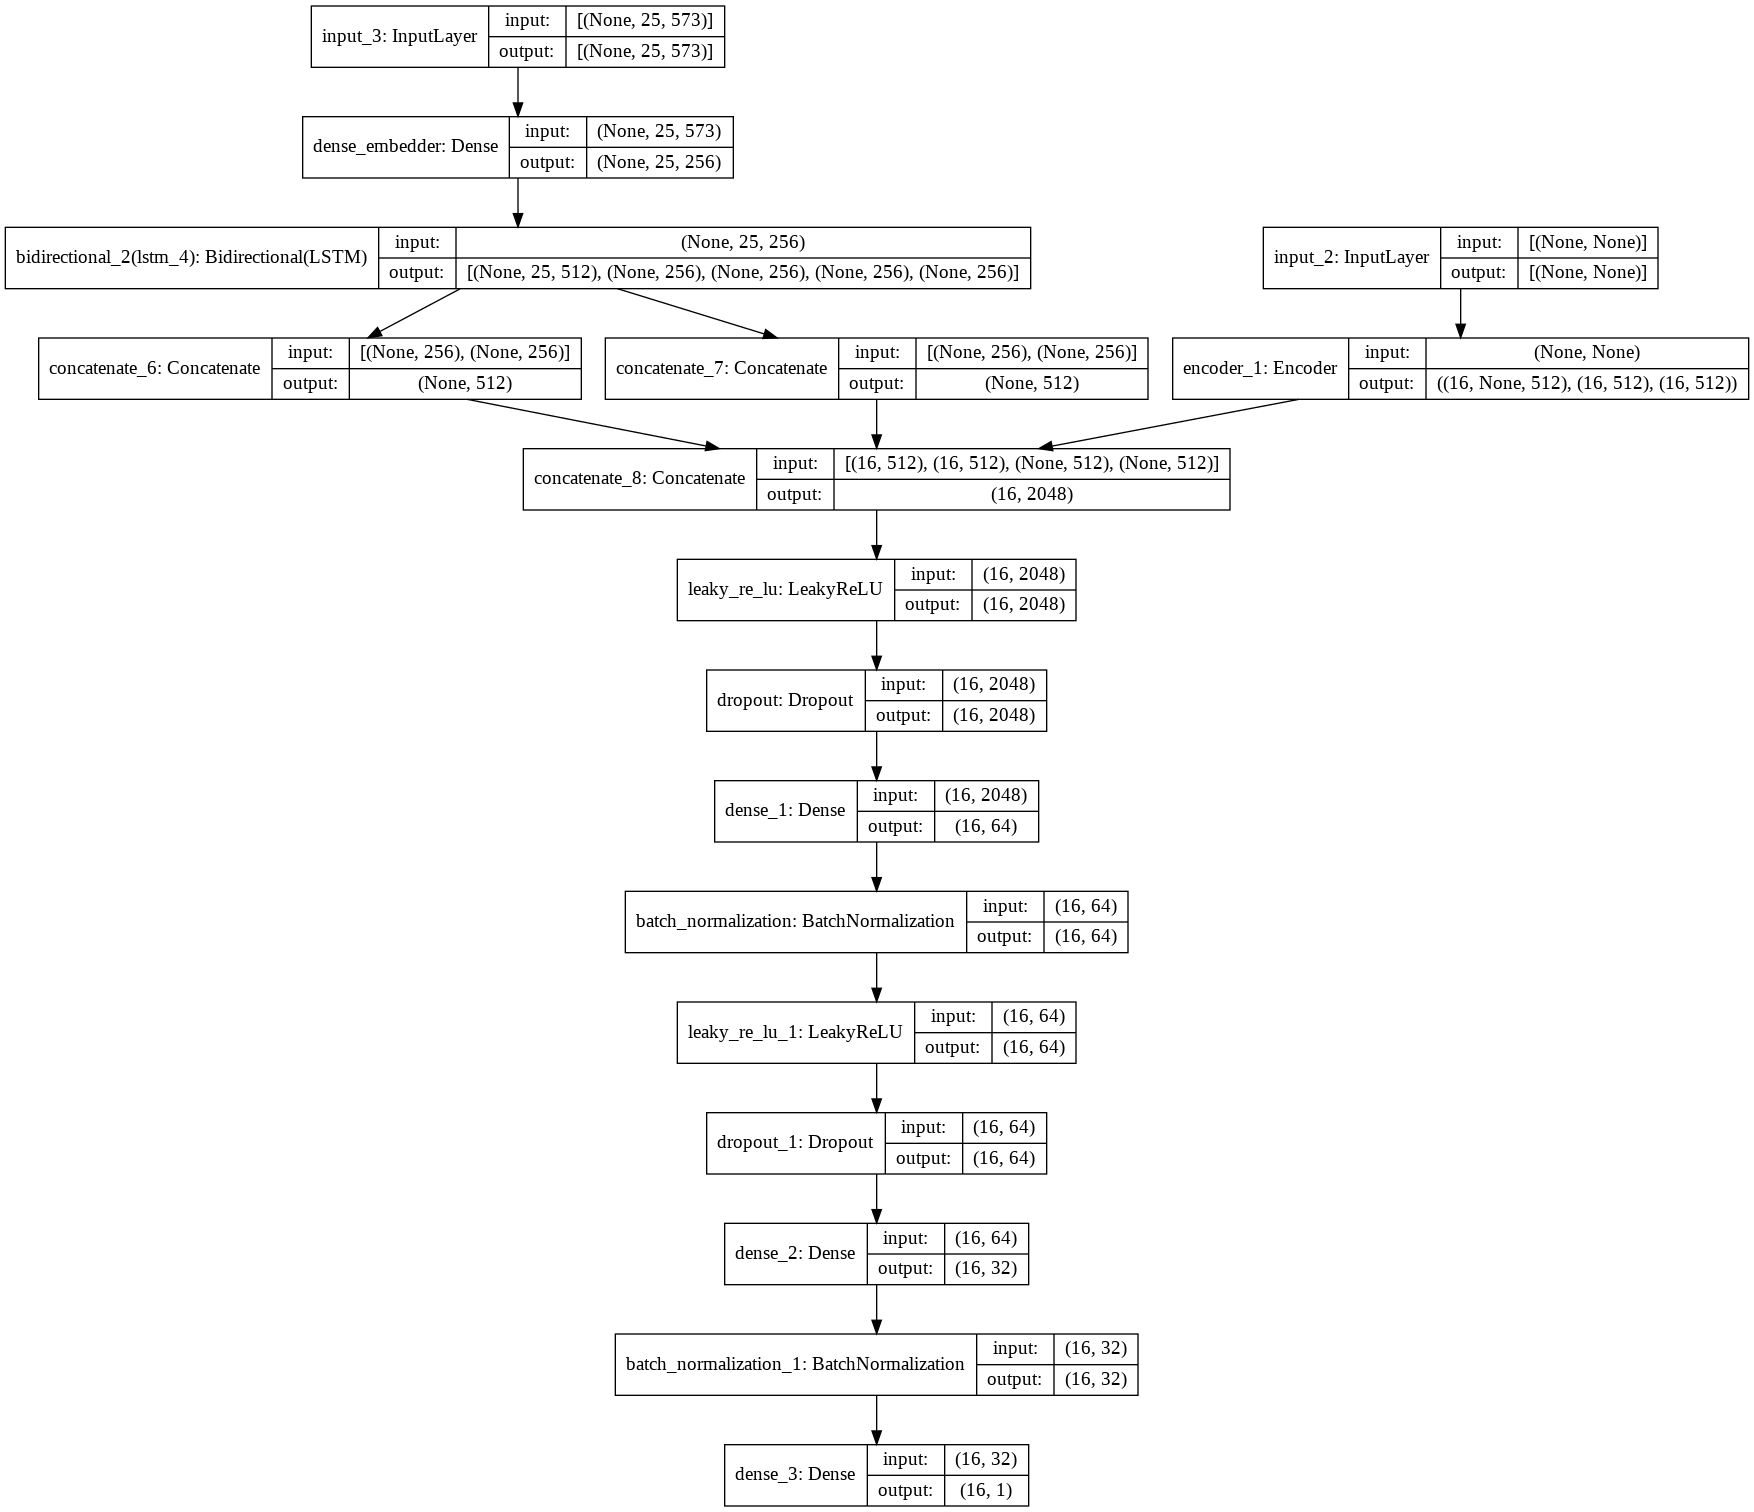

In [ ]:
tf.keras.utils.plot_model(
    discriminator,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

In [ ]:
discriminator([example_input_batch,
               tf.nn.softmax(dec_sample_out.rnn_output)])

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.4959376 ],
       [0.49516737],
       [0.49516556],
       [0.49518555],
       [0.4946578 ],
       [0.49465743],
       [0.49465865],
       [0.49466738],
       [0.49465832],
       [0.49439088],
       [0.49439085],
       [0.494391  ],
       [0.49745908],
       [0.49745888],
       [0.4974583 ],
       [0.49745888]], dtype=float32)>

##TextGAN

In [ ]:
class TextGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, 
                 vocab_tar_size, **kwargs):
        
        super(TextGAN, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.vocab_tar_size = vocab_tar_size
        
    def compile(self, g_opts, d_opts, g_loss_fn, d_loss_fn):
        super(TextGAN, self).compile()
        self.g_opts = g_opts
        self.d_opts = d_opts
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn

    def train_step(self, inputs):
        inp, targ = inputs

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_ans = self.generator([inp, targ], training=True)

            real_out = self.discriminator([inp, 
                                           tf.one_hot(targ[:, :-1], 
                                                      depth=self.vocab_tar_size, 
                                                      dtype=tf.float32)], 
                                          training=True)

            fake_out = self.discriminator([inp, generated_ans], training=True)

            gen_loss = self.g_loss_fn(fake_out)
            disc_loss = self.d_loss_fn(real_out, fake_out)

        gen_vars = self.generator.trainable_variables
        disc_vars = self.discriminator.trainable_variables

        gen_grads = gen_tape.gradient(gen_loss, gen_vars)
        self.g_opts.apply_gradients(zip(gen_grads, gen_vars))

        disc_grads = disc_tape.gradient(disc_loss, disc_vars)
        self.d_opts.apply_gradients(zip(disc_grads, disc_vars))

        return {"gen_loss":gen_loss, "disc_loss":disc_loss}

In [ ]:
text_gan = TextGAN(generator, discriminator, vocab_tar_size)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def generator_predict(encoder, decoder, 
                      sentence, inp_lang, targ_lang, max_length_input, 
                      mode='print', filepath=None, prefix=None):
    
    result, mod_sen = generator_inference(encoder, decoder, 
                                          sentence, 
                                          inp_lang, 
                                          targ_lang, 
                                          max_length_input)
    # print(result)
    result = targ_lang.sequences_to_texts(result)
    mode = mode.lower()
    if mode is None or mode not in ['print', 'save']:
        mode = 'print'

    if mode == 'print':
        print('Input Question: %s\n' % (mod_sen))
        print('Generated Answer: {}'.format(result))
    elif mode == 'save':
        if filepath is None:
            filepath = 'results.txt'

        with open(filepath, 'a') as result_file:
            result_file.write("\n")
            if prefix is not None:
                result_file.write(str(prefix) + "\n")
            result_file.write('Input Question: %s\n' % (mod_sen))
            result_file.write('Generated Answer: {}\n'.format(result))

        print('Results saved to {}'.format(filepath))


def generator_inference(encoder, decoder, sentence, inp_lang, 
                        targ_lang, max_length_input):
    sentence = "<start> " + handler.preprocess_sentence(sentence) \
     + " <end>"

    inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else 0 \
              for i in sentence.split()]
    inputs = tf.convert_to_tensor(
        tf.keras.preprocessing.sequence.pad_sequences(
            [inputs],
            maxlen=max_length_input,
            padding='post'
        )
    )

    inference_batch_size = inputs.shape[0]
    result = ''

    enc_start_state = [tf.zeros((inference_batch_size, latent_dim)) \
                       for i in range(4)]
    enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

    start_tokens = tf.fill([inference_batch_size],
                           targ_lang.word_index['<start>'])
    end_token = targ_lang.word_index['<end>']

    greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

    # Instantiate BasicDecoder object
    decoder_instance = tfa.seq2seq.BasicDecoder(
        cell=decoder.rnn_cell,
        sampler=greedy_sampler, 
        output_layer=decoder.fc,
        maximum_iterations=max_length_output
    )

    # Setup Memory in decoder stack
    decoder.attention_mechanism.setup_memory(enc_out)

    decoder_initial_state = decoder.build_initial_state(
            inference_batch_size, 
            [enc_h, enc_c], 
            tf.float32
    )

    if len(decoder.embedding.variables) == 0:
        raise ValueError("Decoder might have not been trained. " \
                         + "Embedding variables are not initialized" \
                         + "and are empty.")

    decoder_embedding_vector = decoder.embedding.variables[0]

    outputs, _, _ = decoder_instance(decoder_embedding_vector, 
                                        start_tokens=start_tokens, 
                                        end_token=end_token, 
                                        initial_state=decoder_initial_state,
                                    )
    return outputs.sample_id.numpy(), sentence

In [ ]:
class TextGANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, gan, filepath=None, prefix=None, **kwargs):
        super(TextGANMonitor, self).__init__(**kwargs)
        self.gan = gan
        if filepath is None:
            filepath = "results_{}.txt".format(date.today())
        if prefix is None:
            prefix = '_'
        self.filepath = filepath
        self.prefix = prefix

    def on_epoch_end(self, epoch, logs=None):
        ip, tg = next(iter(train_data))
        
        q = ' '.join(inp_lang.index_word[idx] for idx in ip[0].numpy() \
                     if idx > 0)
        
        generator_predict(
            self.gan.generator.encoder,
            self.gan.generator.decoder,
            q,
            inp_lang, 
            targ_lang, 
            max_length_input,
            mode='save',
            filepath=self.filepath,
            prefix='{}_epoch_{}'.format(self.prefix, epoch)
        )

gan_monitor = TextGANMonitor(text_gan)

In [ ]:
ip, tg = next(iter(train_data))
q = ' '.join(inp_lang.index_word[idx] for idx in ip[0].numpy() \
                     if idx > 0)

generator_predict(encoder, decoder, q, inp_lang, targ_lang, max_length_input, mode='save', filepath='test.txt', prefix='0')

Results saved to test.txt


In [ ]:
text_gan.compile(
    g_opts=generator_optimizer,
    d_opts=discriminator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss
)

In [ ]:
text_gan_history=text_gan.fit(
    train_data,
    epochs=50,
    callbacks=[gan_monitor]
)

Epoch 1/50
11/11 [==============================] - 155s 14s/step - gen_loss: 0.7439 - disc_loss: 1.4800
Results saved to results_2021-03-07.txt
Epoch 2/50
11/11 [==============================] - 161s 15s/step - gen_loss: 0.7357 - disc_loss: 1.4696
Results saved to results_2021-03-07.txt
Epoch 3/50
11/11 [==============================] - 158s 14s/step - gen_loss: 0.7256 - disc_loss: 1.4482
Results saved to results_2021-03-07.txt
Epoch 4/50
11/11 [==============================] - 158s 14s/step - gen_loss: 0.7262 - disc_loss: 1.4575
Results saved to results_2021-03-07.txt
Epoch 5/50
11/11 [==============================] - 158s 14s/step - gen_loss: 0.7165 - disc_loss: 1.4389
Results saved to results_2021-03-07.txt
Epoch 6/50
11/11 [==============================] - 159s 15s/step - gen_loss: 0.7258 - disc_loss: 1.4438
Results saved to results_2021-03-07.txt
Epoch 7/50
11/11 [==============================] - 155s 14s/step - gen_loss: 0.7180 - disc_loss: 1.4353
Results saved to results_

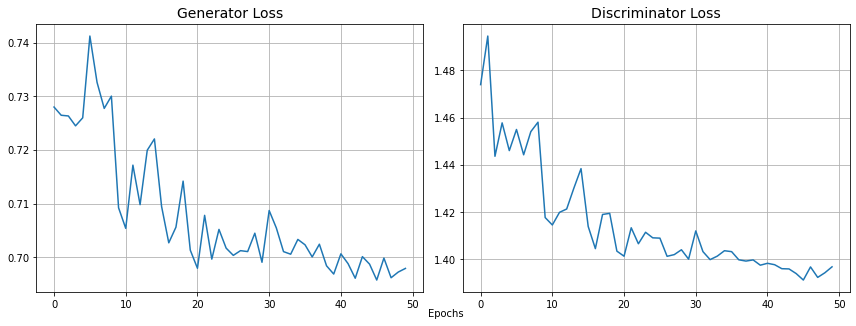

In [ ]:
visualize_gan_loss(text_gan_history)

## Minimax Loss Functions

In [ ]:
def minimax_generator_loss()

##WGAN

In [ ]:
class WGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, d_extra_steps, **kwargs):
        super(WGAN, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.d_extra_steps = d_extra_steps
    
    def compile(self, g_opts, d_opts, g_loss_fn, d_loss_fn):
        super(WGAN, self).compile()
        self.g_opts = g_opts
        self.d_opts = d_opts
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
    
    def train_step(self, inputs):
        inp, targ = inputs

        with t

In [ ]:
wgan_discriminator = get_discriminator(
    Encoder(vocab_inp_size, latent_dim, latent_dim, batch_size),
    ques_shape=(None,),
    ans_shape=dec_sample_out.rnn_output.shape[1:],
    latent_dim=latent_dim,
    is_critic=True
)

In [ ]:
wgan = TextGAN(generator, wgan_discriminator, vocab_tar_size)

In [ ]:
def wgan_discriminator_loss(real_img, fake_img):
    real_loss = tf.math.reduce_mean(real_img)
    fake_loss = tf.math.reduce_mean(fake_img)
    return fake_loss - real_loss

def wgan_generator_loss(fake_img):
    return -tf.math.reduce_mean(fake_img)

wgan.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    wgan_generator_loss,
    wgan_discriminator_loss
)

In [ ]:
wgan_history = wgan.fit(
    train_data,
    epochs=20
)

Epoch 1/20
11/11 [==============================] - 190s 14s/step - gen_loss: -2.8425e-09 - disc_loss: -4.3559e-09
Epoch 2/20
11/11 [==============================] - 160s 15s/step - gen_loss: 8.1491e-10 - disc_loss: -1.3679e-09
Epoch 3/20
11/11 [==============================] - 163s 15s/step - gen_loss: -3.3954e-10 - disc_loss: -1.0962e-09
Epoch 4/20
11/11 [==============================] - 162s 15s/step - gen_loss: 6.7909e-11 - disc_loss: 2.9104e-11
Epoch 5/20
11/11 [==============================] - 161s 15s/step - gen_loss: 1.4552e-10 - disc_loss: 8.7311e-11
Epoch 6/20
 3/11 [=======>......................] - ETA: 1:54 - gen_loss: 9.3132e-10 - disc_loss: -2.4835e-09

KeyboardInterrupt: ignored

In [ ]:
visualize_gan_loss(wgan_history)